In [1]:
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import f1_score, make_scorer, accuracy_score
import matplotlib.pyplot as plt

In [2]:
X, y = load_iris(return_X_y=True)
X = pd.DataFrame(X, columns=load_iris().feature_names)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [4]:
model = LogisticRegression(max_iter=5000, solver='liblinear', multi_class='auto')

In [5]:
f1_macro = make_scorer(f1_score, average='macro')

In [6]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

RFE: Automated Feature-Count Tuning with F1 Score

In [7]:
best_k = 0
best_f1 = 0
best_features_rfe = []

In [8]:
for k in range(1, X.shape[1] + 1):
    rfe = RFE(estimator=model, n_features_to_select=k)
    scores = cross_val_score(rfe, X_train, y_train, cv=cv, scoring=f1_macro, n_jobs=-1)
    mean_score = scores.mean()

    if mean_score > best_f1:
        best_f1 = mean_score
        best_k = k
        best_features_rfe = rfe.fit(X_train, y_train).get_support()

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and wi

In [10]:
print(f"RFE Optimal Feature Count: {best_k}")
selected_rfe = X.columns[best_features_rfe]
print("RFE Selected Features:", list(selected_rfe))

RFE Optimal Feature Count: 4
RFE Selected Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [11]:
model.fit(X_train[selected_rfe], y_train)
y_pred_rfe = model.predict(X_test[selected_rfe])
acc_rfe = accuracy_score(y_test, y_pred_rfe)
f1_rfe = f1_score(y_test, y_pred_rfe, average='macro')
print(f"RFE Test Accuracy: {acc_rfe:.4f}")
print(f"RFE Test F1 Score: {f1_rfe:.4f}")

RFE Test Accuracy: 0.8947
RFE Test F1 Score: 0.8949


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


RFECV: Recursive + CV + CountTuning

In [12]:
rfecv = RFECV(
    estimator=model,
    step=1,
    cv=cv,
    scoring=f1_macro,
    n_jobs=-1,
    min_features_to_select=1
)
rfecv.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


RFECV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
      estimator=LogisticRegression(max_iter=5000, multi_class='auto',
                                   solver='liblinear'),
      n_jobs=-1,
      scoring=make_scorer(f1_score, response_method='predict', average=macro))

In [13]:
selected_rfecv = X.columns[rfecv.get_support()]
print(f"RFECV Optimal Feature Count: {rfecv.n_features_}")
print("RFECV Selected Features:", list(selected_rfecv))

RFECV Optimal Feature Count: 4
RFECV Selected Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [14]:
model.fit(X_train[selected_rfecv], y_train)
y_pred_rfecv = model.predict(X_test[selected_rfecv])
acc_rfecv = accuracy_score(y_test, y_pred_rfecv)
f1_rfecv = f1_score(y_test, y_pred_rfecv, average='macro')
print(f"RFECV Test Accuracy: {acc_rfecv:.4f}")
print(f"RFECV Test F1 Score: {f1_rfecv:.4f}")

RFECV Test Accuracy: 0.8947
RFECV Test F1 Score: 0.8949


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


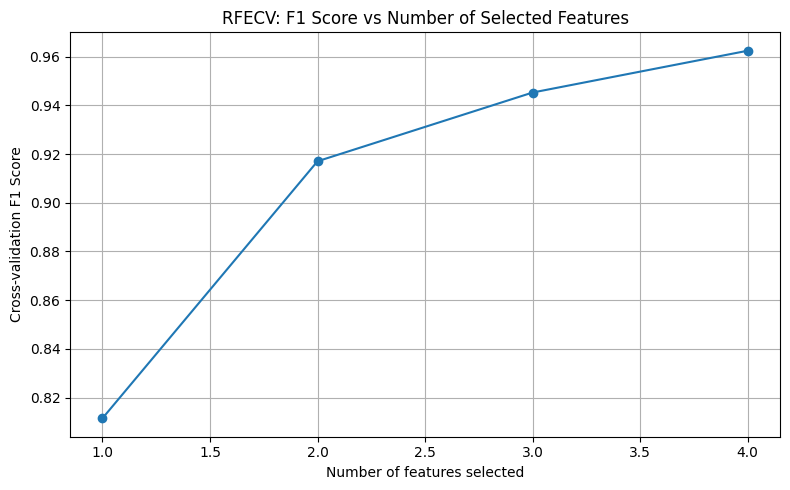

In [15]:
plt.figure(figsize=(8, 5))
plt.xlabel("Number of features selected")
plt.ylabel("Cross-validation F1 Score")
plt.plot(range(1, len(rfecv.cv_results_['mean_test_score']) + 1),
         rfecv.cv_results_['mean_test_score'], marker='o')
plt.title("RFECV: F1 Score vs Number of Selected Features")
plt.grid(True)
plt.tight_layout()
plt.show()